# Xephyr library is loaded and you can use all classes and methods
### Now we are going to set up the SR0 likelihood.


The first step is to load the Xephyr library:

In [1]:
gROOT->ProcessLine(".x ../loadXephyr.C");  // This is basically ".x loadXephyr.C



      =================== Welcome to Xephyr =====================
       Version 6.0 dated 10-Oct-2017, compiled with ROOT 6.08/00

(int) 0


Next we declare the variables and objects we will use later. This is done early and on a top cell so you can rerun other cells below several times without the notebook complaining about redeclarations. 
So in general, feel free to put these lines along the code as you wish (as long as it is before you use that declarable):

In [2]:
TString ER_file;
pdfComponent *ER=0;
shapeSys *PY=0;
shapeSys *RF=0;
scaleSys *s1=0;
TCanvas *c1 = new TCanvas();
TCanvas *c2 = new TCanvas();
TCanvas *c3 = new TCanvas();
TCanvas *c4 = new TCanvas();
TH2F h1,h2,h3;
TString Signal_file;
pdfComponent *Signal = 0;
shapeSys *Gamma = 0 ;
shapeSys *Alpha = 0 ;
shapeSys *Lambda = 0;
shapeSys *ExEff = 0; //OK 
histoCompare p;
TString data_filename;
TString data_treeName;
dataHandler *data = 0;
AsymptoticExclusion *as=0;

errorHandler::globalPrintLevel = 1;  // print level 3 = Error only , 2 = Warning,  1= Info, 0 = Debug



### We start from defining the input PDFs and their related uncertaintied:
this is done via a class called pdfComponent, its constructor take the following arguments:

```c++
pdfComponent::pdfComponent(TString name, TString filename) 
```

where "name" must be the prefix of the histogram from which you are loading this component, and "filename" is the file with its complete path.

**REMINDER:**
- The only supported histo name structure is the following:
- Must prefix_XXname_YY_name2_


In [4]:
ER_file = "data_examples/DMTemplatesReweighted_lax0.11.1_V12.root";
delete ER;
ER = new pdfComponent("hband", ER_file);

 Reading file data_examples/DMTemplatesReweighted_lax0.11.1_V12.root


In [5]:
 //Now some settings:
        ER->setScaleFactor(63.);                    // Set the normalization factor for ER in events.
        delete PY;
        PY = new shapeSys("_PY");         // 
        PY->setStep(0.5);     
        PY->setMinimum(-2.);   
        PY->setMaximum(2.);    
//      PY->setType(FIXED_PARAMETER);
        delete RF;
        RF = new shapeSys("_RF");
        RF->setStep(0.5);     
        RF->setMinimum(-2.);   
        RF->setMaximum(2.);    
//      RF->setType(FIXED_PARAMETER);
//      shapeSys *Thr = new shapeSys("_Threshold");
//      Thr->setStep(0.5);     
//      shapeSys *Ne = new shapeSys("_NexNi");
//      Ne->setStep(0.5);      
        delete s1;
        s1 = new scaleSys("ERscale",0.12); 
        s1->setType(FREE_PARAMETER);
        ER->addScaleSys(s1);   
        ER->addShapeSys(PY);   
        ER->addShapeSys(RF);
        //ER->addShapeSys(Thr);
        //ER->addShapeSys(Ne); 

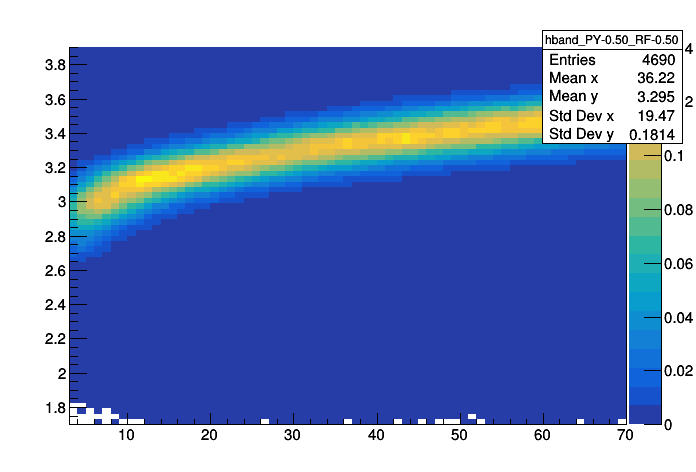

In [6]:
c1->cd();
 h1 = ER->getInterpolatedHisto();
h1.Draw("colz");
c1->Draw("*");

Now you couold for example change the value of one of the nuissance parameter and get the relative histogram interpolated... Let's do that!

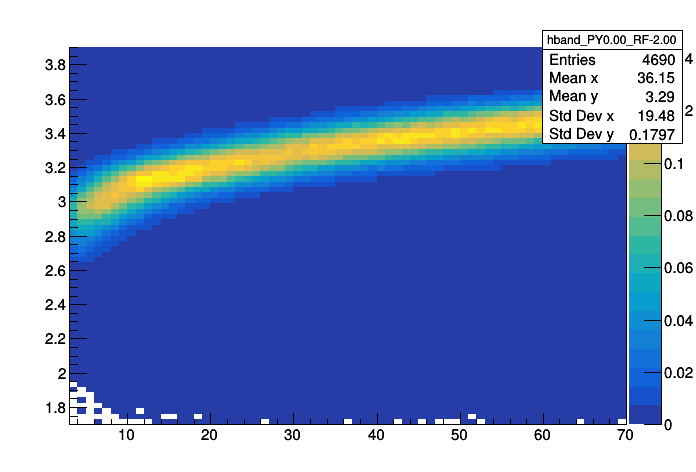

In [7]:
c2->cd();
RF->setCurrentValue(-1.7);               // Setting the value of RF to -1.7 sigma from its standard value (rememer the value will be interpolated)
PY->setCurrentValue(0.35);
h2 = ER->getInterpolatedHisto();
h2.Draw("colz");
c2->Draw();

##### Now let's add a Signal PdfComponent

In [8]:
        Signal_file ="data_examples/wimp_0050gev_variations_lax_0.11.1.root" ;
        delete Signal;
        Signal = new pdfComponent( "wimp_0050gev", Signal_file);

        Signal->setScaleFactor(34.2 * 1.0418);
        Signal->suffix= "sigma";

//        scaleSys *s2 = new scaleSys("scaleS",0.1);
//      Signal->addScaleSys(s2);
        delete Gamma;
        Gamma = new shapeSys("_gamma_");
      Gamma->setStep(1);
        delete Alpha;
        Alpha = new shapeSys("_alpha_");  // OK
      Alpha->setStep(1);
        delete Lambda;
        Lambda = new shapeSys("_eta_");
      Lambda->setStep(1);
 //     shapeSys *Lambda = new shapeSys("_lambda_");
        delete ExEff;
        ExEff = new shapeSys("_acceptance_par_");  //OK 
//      ExEff->setStep(1);
//      shapeSys *ExEff = new shapeSys("_extraction_efficiency_");

        Gamma->setType(FIXED_PARAMETER);
        Alpha->setType(FIXED_PARAMETER);
        Lambda->setType(FIXED_PARAMETER);
        ExEff->setType(FIXED_PARAMETER);

        Signal->addShapeSys(Gamma);
        Signal->addShapeSys(Alpha);
        Signal->addShapeSys(Lambda);
        Signal->addShapeSys(ExEff);


 Reading file data_examples/wimp_0050gev_variations_lax_0.11.1.root


In [9]:
cout << Gamma->getName();

_gamma_

#### And let's draw it, just for fun...

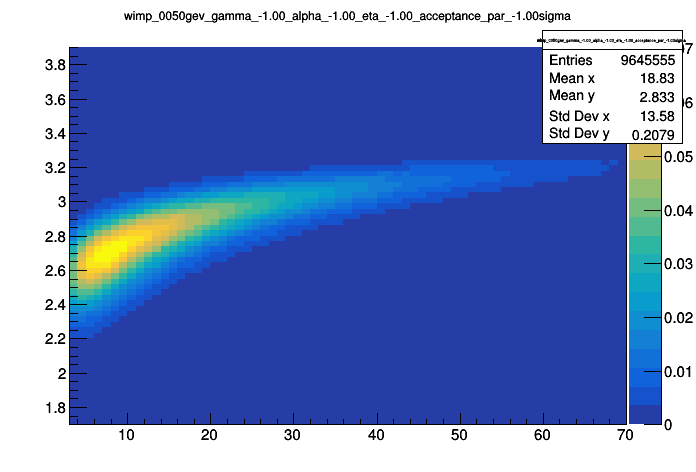

In [10]:
c3->cd();
h3 = Signal->getInterpolatedHisto();
h3.Draw("colz");
c3->Draw();

#### Now let's add some data

In [11]:
data_filename = "./data_examples/xephyr_data_none_lowenergy_roi.root";
data_treeName = "DMtree";
delete data;
data = new dataHandler("dmData",data_filename, data_treeName);

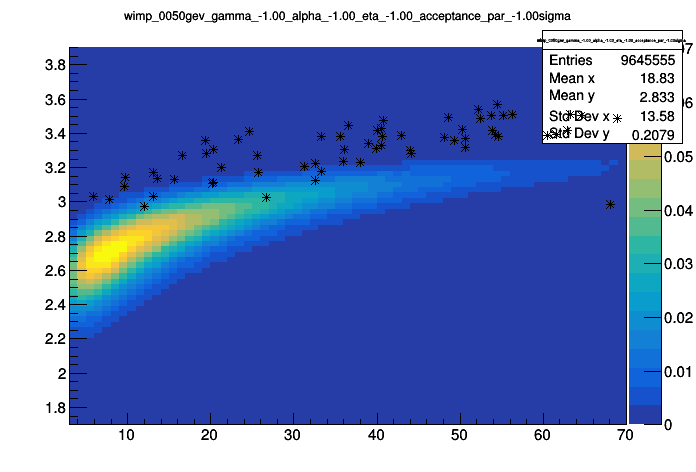

In [12]:
data->drawS1S2("p*");//("same*");
c3->Draw();

# Now it's time for some likelihood game

In [13]:
pdfLikelihood pl("xe1t",50);
pl.setExperiment(1);
//pl.addBkgPdfComponent(flat, true);
//pl.addBkgPdfComponent(radio, false);
//pl.addBkgPdfComponent(cnns, false);
//pl.addBkgPdfComponent(AC, false);
//pl.addBkgPdfComponent(wall, false);
pl.addBkgPdfComponent(ER, true);
pl.setSignalPdf(Signal);       
pl.setSignalDefaultNorm(1.E-45);
//pl.setPrintLevel(0);
pl.setDataHandler(data);       
  
//pl.setCalibrationData(radon220);
pl.setWithSafeGuard(false);    
//pl.setAdditionalSafeGuardComponent(ACforSafeguard);
  
pl.initialize();


pdfLikelihood - INFO: bkg component named hband added to    SAFEGUARDED
pdfLikelihood::initialize - INFO :  initialize..... 
	Likelihood::addParameter - Info : Adding parameter Sigma  with ID -1  to PL xe1t
INFO :  adding sys for BKG component hband
	Likelihood::addParameter - Info : Adding parameter ERscale  with ID 1  to PL xe1t
	Likelihood::addParameter - Info : Adding parameter _PY  with ID 2  to PL xe1t
	Likelihood::addParameter - Info : Adding parameter _RF  with ID 3  to PL xe1t
INFO :  adding sys for SIGNAL component wimp_0050gev
	Likelihood::addParameter - Info : Adding parameter _gamma_  with ID 4  to PL xe1t
	Likelihood::addParameter - Info : Adding parameter _alpha_  with ID 5  to PL xe1t
	Likelihood::addParameter - Info : Adding parameter _eta_  with ID 6  to PL xe1t
	Likelihood::addParameter - Info : Adding parameter _acceptance_par_  with ID 7  to PL xe1t

------ WARNING -------  Safeguard is turned OFF altough you have set components to be safeguarded this is ignored --

In [14]:
//pl.maximize(false);             
pl.printCurrentParameters(); 
//pl.printInitialParameters();

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _PY                  Nuisance        0.35                 
  3 _RF                  Nuisance        -1.7                 
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 


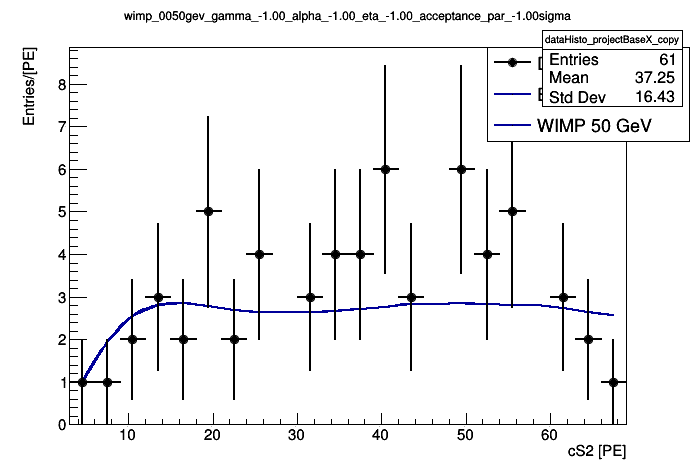

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _PY                  Nuisance        0.35                 
  3 _RF                  Nuisance        -1.7                 
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
Data   63
Bkg    63
Signal 0 POI 0  SignalMultiplier  0.0602386
...... That signal scaled is 0


Info in <TH1D::Add>: Attempt to add histograms with different bin limits - trying to use TH1::Merge


In [15]:
// class example to compare histograms
p = pl.getModelCompare();
//p.setNameofComponent(1,"flat");
//p.setNameofComponent(1,"AC");
p.setNameofComponent(1,"ER");
p.setNameofComponent(2,"WIMP 50 GeV");
p.rebinY = 1;
p.rebinX = 3;
p.doStack = true;
p.titleY="Entries/[PE]";
p.titleX="cS2 [PE]";
p.projectionMin = 3;
p.projectionMax = 3.6;
p.projectionX = true;
//p.compareWithRatio();
c4->cd();
p.compare();

c4->Draw();

In [16]:
delete as;
as= new AsymptoticExclusion( &pl, 0.1);  // 0.1  --> means 90% CLs
  

  
//just compute the sensitivity 
//  as.computeSensitivity();
  
as->setNscanPoints(100);   // set the number of scan points for limit computation, the pvalues are computed in steps of the parameter of interest untill the CL is reached.
//as.setScanMax(100.);    // Set the range of the scan (default 3 sigma from expected sensitivity)
//as.setScanMin(0.);      // Set the range of the scan (default 0.) 
  
  
as->setQTilde(true);            

In [17]:
as->computeLimits();       // compute the sensitivity first then the CLs limit
  
//as.LikelihoodScan();
  
as->writeToFile("example_limit_"); 


 ------- START-------- 
 AsymptoticExclusion::unconditionalFit() 
Finding maximum of xe1t
Total of 4 active parameters, don't freeze parameters of interest, Minuit fits 4 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 ERscale              Free               0                 
  2 _PY                  Nuisance           0                 
  3 _RF                  Nuisance           0                 
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
ML -231.55 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest     0.24 +- 2.7      
  1 ERscale              Free          -0.031 +- 1.5      
  2 _PY            

ML -232.866 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           4.2                 
  1 ERscale              Free           -0.25 +- 1.4      
  2 _PY                  Nuisance       -0.41 +- 1.2      
  3 _RF                  Nuisance       -0.34 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           4.2                 
  1 ERscale              Free           -0.25                 
  2 _PY                  Nuisance       -0.41                 
  3 _RF                  Nuisance       -0.34                 
  4 _gamma_              Fixed              0                 
  5 _alpha_

ML -232.343 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.2                 
  1 ERscale              Free           -0.22 +- 1.5      
  2 _PY                  Nuisance       -0.39 +- 1.2      
  3 _RF                  Nuisance        -0.3 +- 1.3      
  4 _gamma_              Fixed              0                 
  5 _alpha_              Fixed              0                 
  6 _eta_                Fixed              0                 
  7 _acceptance_par_     Fixed              0                 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           3.2                 
  1 ERscale              Free           -0.22                 
  2 _PY                  Nuisance       -0.39                 
  3 _RF                  Nuisance        -0.3                 
  4 _gamma_              Fixed              0                 
  5 _alpha_

Warning in <TFile::Append>: Replacing existing TH1: pullsHisto (Potential memory leak).


# If you go at the bottom of the previous print out you'll see the result:
```
OBSERVED limit not scaled mu 3.42441  cross section no cLS 2.06282e-46  test stat value no cls -999  cross section  2.06282e-46  test stat value -999
```

The important number is cross section no CLs 2.06e-46 cm^2